In [ ]:
# Importing necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import astropy.io.ascii
import astropy.constants as ac
import astropy.units as u

In [ ]:
import sys
print(sys.version)

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


In [ ]:
# Load the drive helper and mount
from google.colab import drive

# This will prompt for authroities
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
# Grabbing file from drive
tab = astropy.io.ascii.read("/content/drive/MyDrive/Astron_5205/PS_2025.01.16_06.39.23.csv").to_pandas()
tab = tab.drop_duplicates(subset = "pl_name")

In [ ]:
# Printing tab column names
print(tab.columns)
tab = tab[((tab["pl_rade"] < 30))]

Index(['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum',
       'discoverymethod', 'disc_year', 'disc_facility', 'soltype',
       'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1',
       'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1',
       'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2',
       'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2',
       'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2',
       'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1',
       'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1',
       'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2',
       'pl_eqtlim', 'ttv_flag', 'st_refname', 'st_spectype', 'st_teff',
       'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1',
       'st_raderr2', 'st_radlim', 'st_mass', 'st_masserr1', 'st_masserr2

In [ ]:
# Create a dictionary of planet data
planet_data = {
    'Planet': ['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune'],
    'Mass (Earth masses)': [0.055, 0.815, 1.000, 0.107, 317.8, 95.2, 14.5, 17.1],
    'Radius (Earth radii)': [0.383, 0.950, 1.000, 0.532, 11.21, 9.45, 4.01, 3.88],
    'Period (days)': [88.0, 224.7, 365.2, 687.0, 4331, 10747, 30589, 59800],
    'Semi-major axis (AU)': [0.387, 0.723, 1.000, 1.524, 5.203, 9.537, 19.191, 30.069],
    'Average color': ['#E5E5E5', '#877882', '#1E90FF', '#BC2732', '#FFA500', '#C4B08B', '#ADD8E6', '#00008B']
}

# Create a pandas DataFrame from the dictionary
planet_df = pd.DataFrame(planet_data)


In [ ]:
# Making transsit lines
per_arr = 10.0**(np.arange(8.5)-.5) * u.day

rad_per_arr = (3 * (per_arr / (365 * u.day))** 0.5)** 0.5 * u.earthRad

def radius_to_mass(r):
  r = r / u.earthRad
  if r <= 1.2141948844:
    return r**(1/.28)
  elif r <= 12.5029046539:
    return  17.15*(r/3.88)**(1/.59)
  else:
    return .4*(u.jupiterMass/u.earthMass)

mass_per_arr = [radius_to_mass(r) for r in rad_per_arr]

def per_to_sma(t):
  t = t / u.day
  return (t/365)**(2/3)

sma_per_arr = [per_to_sma(t) for t in per_arr]



In [ ]:
# Making Radial Velocity lines
sma_arr = 10.0**(np.arange(8)-2.5) * u.AU

mass_sma_arr = 0.5 * u.meter / u.second * u.solMass * np.sqrt(sma_arr / ac.G / (u.solMass))

def mass_to_radius(m):
  m = m / u.earthMass
  if m <= 2:
    return m**.28
  elif m <= .4*(u.jupiterMass/u.earthMass):
    return 3.88*(m/17.15)**.59
  elif m <= .08*(u.solMass/u.earthMass):
    return 11.2*(m/317.9)**-.04
  else:
    return 109*(m/333000)**.88

rad_sma_arr = [mass_to_radius(m) for m in mass_sma_arr]

def sma_to_per(a):
  a = a / u.AU
  return 365*a**(3/2)

per_sma_arr = [sma_to_per(a) for a in sma_arr]

In [ ]:
tab[tab["discoverymethod"]=="Imaging"]["sy_dist"].median()

41.0012

In [ ]:
# Making Direct Imaging lines
DI_rad_lim = u.solRad.to(u.earthRad)*(1e-7/((u.solRad.to(u.m)/(2*u.AU.to(u.m)))**2+(np.exp(ac.h*ac.c*288*u.K/(ac.b_wien*ac.k_B*5770*u.K))-1)/(np.exp(ac.h*ac.c/(ac.b_wien*ac.k_B))-1)))**.5 *u.earthRad
print(DI_rad_lim)
DI_sma_lim = (1.22*tab[tab["discoverymethod"]=="Imaging"]["sy_dist"].median()*u.pc*ac.b_wien/(8*u.m*288*u.K)).to(u.AU)
print(DI_sma_lim)
DI_mass_lim = radius_to_mass(DI_rad_lim)
DI_per_lim = sma_to_per(DI_sma_lim)
DI_rad_lim = DI_rad_lim.value
DI_sma_lim = DI_sma_lim.value

0.7748937178190742 earthRad
12.976670033289768 AU


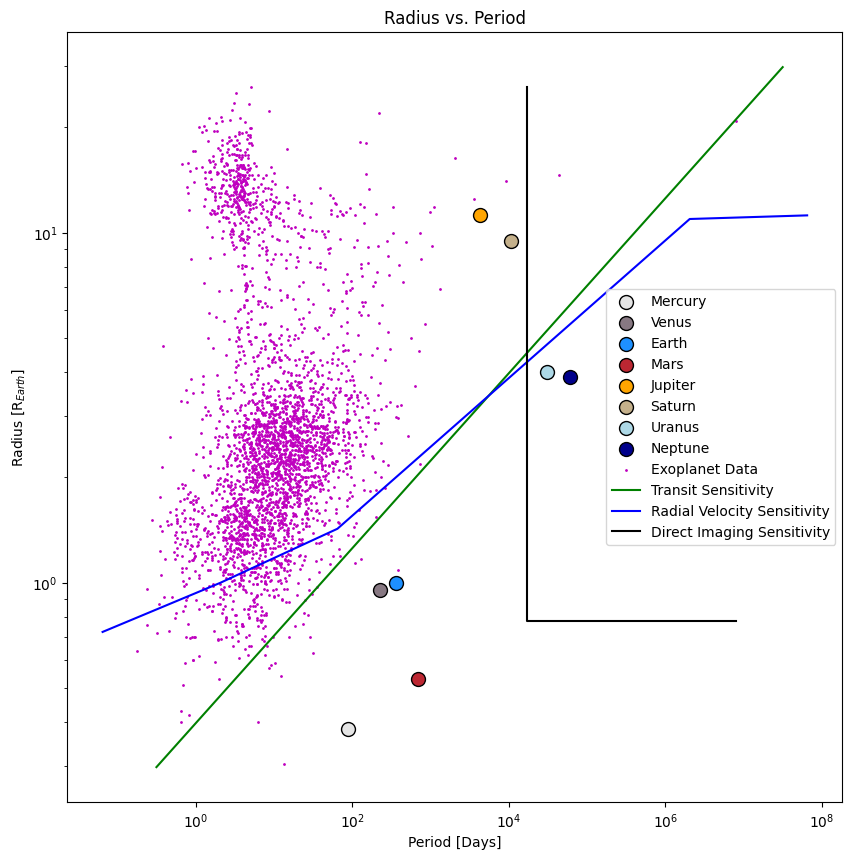

In [ ]:
# Set figure size
plt.figure(figsize=(10, 10))
plt.tight_layout()

# Plot x and y, adjust size of data points, make the data points magenta
for i in planet_df.index:
  plt.scatter(planet_df["Period (days)"][i], planet_df["Radius (Earth radii)"][i], s=100, linewidths=1, edgecolors="black", c=planet_df["Average color"][i], label=planet_df["Planet"][i])
plt.scatter(tab["pl_orbper"], tab["pl_rade"], s=1, c="m", label="Exoplanet Data")

# Lines showing sensitivities
plt.plot(per_arr.value, rad_per_arr.decompose().to(u.earthRad), color="g", label="Transit Sensitivity")
plt.plot(per_sma_arr[:7], rad_sma_arr[:7], color="b", label="Radial Velocity Sensitivity")
plt.plot([DI_per_lim,DI_per_lim,tab["pl_orbper"].max()],[tab["pl_rade"].max(),DI_rad_lim,DI_rad_lim], color="black", label="Direct Imaging Sensitivity")

# Set the scale for the x and y axes
plt.xscale("log")
plt.yscale("log")

# Label x and y axes
plt.xlabel("Period [Days]")
plt.ylabel(r"Radius [R$_{Earth}$]")

# Add title
plt.title("Radius vs. Period")
plt.legend()
plt.show()

## 1, How about Mass-Period plot, Mass-Semi-major axis plot, etc? How different are they and why?


## 2, Overplot solar system planets on the above plot?

## 3, Research on the state-of-the-art performance of each detection technique and overplot the sensitivity line. An example of RV is given below.

## $K = \frac{m_p}{m_\ast}\cdot\sqrt{\frac{Gm_\ast}{a}}\cdot\sin i$

## Assuming an edge-on orbit, for which $i$ is 90 degree, rearrange the equation to be:

## $m_p = K \cdot m_\ast \cdot \sqrt{\frac{a}{Gm_\ast}}$

## For a K value of 0.5 m/s, which is the state-of-the-art performance, the mass sensitivity is as follows for a range of semi major axis $a$, assuming 1 solar mass:

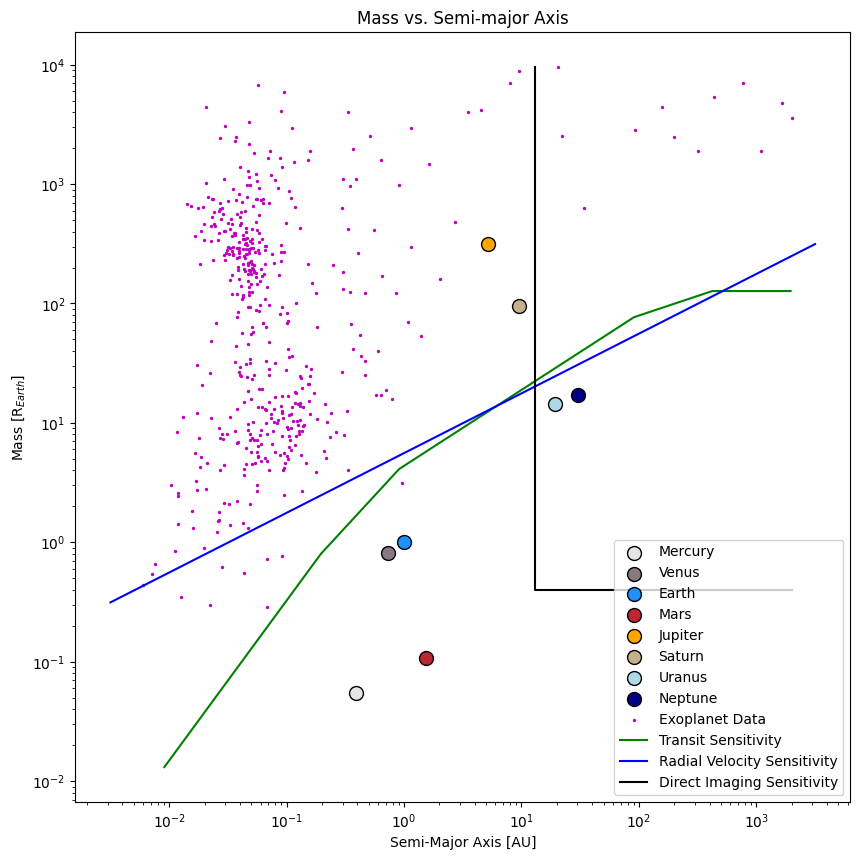

In [ ]:
# Set figure size
plt.figure(figsize=(10, 10))
plt.tight_layout()

# Plot x and y, adjust data point size and make them magenta
for i in planet_df.index:
  plt.scatter(planet_df["Semi-major axis (AU)"][i], planet_df["Mass (Earth masses)"][i], s=100, linewidths=1, edgecolors="black", c=planet_df["Average color"][i], label=planet_df["Planet"][i])
plt.scatter(tab["pl_orbsmax"], tab["pl_bmasse"], c="m", s=2, label="Exoplanet Data")

# Lines showing sensitivities
plt.plot(sma_per_arr, mass_per_arr, color="g", label="Transit Sensitivity")
plt.plot(sma_arr[:7].value, mass_sma_arr[:7].decompose().to(u.earthMass), color="b", label="Radial Velocity Sensitivity")
plt.plot([DI_sma_lim,DI_sma_lim,tab["pl_orbsmax"].max()],[tab["pl_bmasse"].max(),DI_mass_lim,DI_mass_lim], color="black", label="Direct Imaging Sensitivity")

# Scale x and y axes
plt.xscale("log")
plt.yscale("log")

# Add label to x and y axes
plt.xlabel("Semi-Major Axis [AU]")
plt.ylabel(r"Mass [R$_{Earth}$]")

# Add title
plt.title("Mass vs. Semi-major Axis")

plt.legend()
plt.show()

## You may think about the conversin between mass and radius  when considering the sensitivity of other detection techniques.

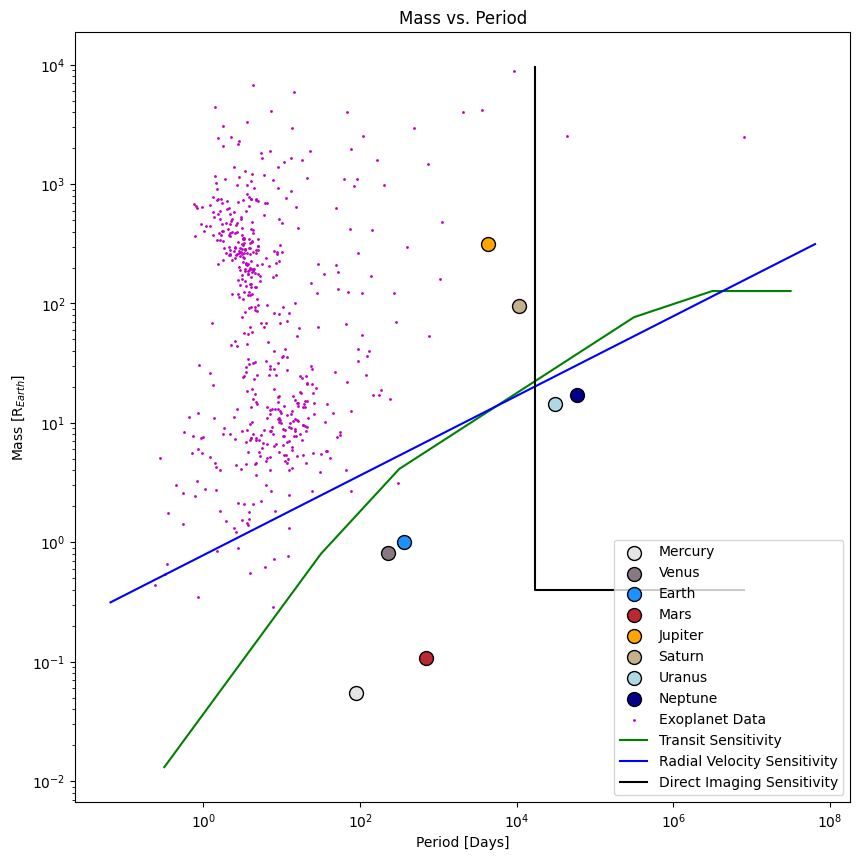

In [ ]:
# Set figure size
plt.figure(figsize=(10, 10))
plt.tight_layout()

# Plot x and y, adjust size of data points, make the data points magenta
for i in planet_df.index:
  plt.scatter(planet_df["Period (days)"][i], planet_df["Mass (Earth masses)"][i], linewidths=1, edgecolors="black", s=100, c=planet_df["Average color"][i], label = planet_df["Planet"][i])
plt.scatter(tab["pl_orbper"], tab["pl_bmasse"], s=1, c="m", label="Exoplanet Data")

# Lines showing sensitivities
plt.plot(per_arr.value, mass_per_arr, color="g", label="Transit Sensitivity")
plt.plot(per_sma_arr[:7], mass_sma_arr[:7].decompose().to(u.earthMass), color="b", label="Radial Velocity Sensitivity")
plt.plot([DI_per_lim,DI_per_lim,tab["pl_orbper"].max()],[tab["pl_bmasse"].max(),DI_mass_lim,DI_mass_lim], color="black", label="Direct Imaging Sensitivity")

# Set the scale for the x and y axes
plt.xscale("log")
plt.yscale("log")

# Label x and y axes
plt.xlabel("Period [Days]")
plt.ylabel(r"Mass [R$_{Earth}$]")

# Add title
plt.title("Mass vs. Period")

plt.legend()
plt.show()

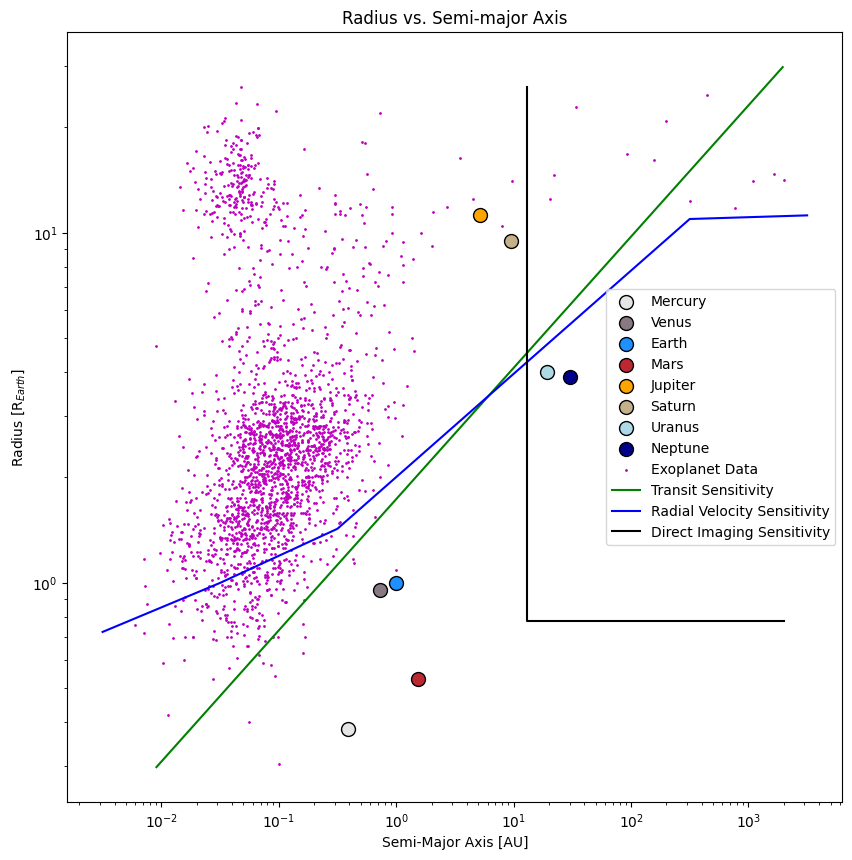

In [ ]:
# Set figure size
plt.figure(figsize=(10, 10))
plt.tight_layout()

# Plot x and y, adjust size of data points, make the data points magenta
for i in planet_df.index:
  plt.scatter(planet_df["Semi-major axis (AU)"][i], planet_df["Radius (Earth radii)"][i], s=100, linewidths=1, edgecolors="black", c=planet_df["Average color"][i], label = planet_df["Planet"][i])
plt.scatter(tab["pl_orbsmax"], tab["pl_rade"], s=1, c="m", label = "Exoplanet Data")

# Lines showing sensitivities
plt.plot(sma_per_arr, rad_per_arr, color="g", label="Transit Sensitivity")
plt.plot(sma_arr.value[:7], rad_sma_arr[:7], color="b", label="Radial Velocity Sensitivity")
plt.plot([DI_sma_lim,DI_sma_lim,tab["pl_orbsmax"].max()],[tab["pl_rade"].max(),DI_rad_lim,DI_rad_lim], color="black", label="Direct Imaging Sensitivity")

# Set the scale for the x and y axes
plt.xscale("log")
plt.yscale("log")

# Label x and y axes
plt.xlabel("Semi-Major Axis [AU]")
plt.ylabel(r"Radius [R$_{Earth}$]")

# Add title
plt.title("Radius vs. Semi-major Axis")

plt.legend()
plt.show()

In [ ]:
# Calculate observed signals for an earth-like planet around a sun-like star

In [ ]:
def transit_signal(rad, per, obs):
  rad = rad/u.earthRad
  per = per/u.day
  obs = obs/u.day
  return ((rad*u.earthRad/u.solRad.to(u.earthRad))**2 * (obs/per)**.5 / .0001).value

def radial_velocity_signal(sma, mass):
  sma = sma.to(u.m)
  mass = mass.to(u.earthMass)
  return ((mass/u.solMass.to(u.earthMass)) * (ac.G*ac.M_sun/sma)**.5).value

def direct_imaging_signal(sma, rad, temp):
  sma = sma.to(u.m)
  rad = rad.to(u.earthRad)
  temp = temp.to(u.K)
  return (rad/u.solRad.to(u.earthRad))**2 * (((ac.R_sun/(2*sma))**2).value+(np.exp(ac.h*ac.c/(ac.k_B*5770*u.K*ac.b_wien/temp))-1)/(np.exp(ac.h*ac.c/(ac.k_B*ac.b_wien))-1))

def direct_imaging_seperation(dist,sma):
  dist = dist.to(u.m)
  sma = sma.to(u.m)
  return (sma/dist).value

def rayleigh_criteria(temp,dia):
  temp = temp.to(u.K)
  dia = dia.to(u.m)
  return 1.22*(ac.b_wien/(temp*dia))

def observable_dist(sma,temp,dia):
  sma = sma.to(u.m)
  temp = temp.to(u.K)
  dia = dia.to(u.m)
  return temp*sma*dia/(1.22*ac.b_wien)

In [ ]:
print("Earth signals around a sun-like star:")
print("transit signal:",transit_signal(u.earthRad,365*u.day,90*u.day))
print()
print("radial velocity signal:",radial_velocity_signal(u.AU,u.earthMass),"m/s")
print()
print("direct imaging signal:",direct_imaging_signal(u.AU,u.earthRad,(288*u.K)))
print()
print("direct imaging seperation:",direct_imaging_seperation(tab[tab["discoverymethod"]=="Imaging"]["sy_dist"].median()*u.pc,u.AU))
print()
print("rayleigh criteria for earth:",rayleigh_criteria(288*u.K,8*u.m))
print()
print("maximum distance to resolve earth:",observable_dist(u.AU,288*u.K,8*u.m)*u.m.to(u.pc),"pc")

Earth signals around a sun-like star:
transit signal: 0.4173625373399848

radial velocity signal: 0.08945800466923792 m/s

direct imaging signal: 1.6653891080574303e-07

direct imaging seperation: 1.1824377850149167e-07

rayleigh criteria for earth: 1.5344104971032598e-06

maximum distance to resolve earth: 3.1596087358942904 pc
